In [2]:
import os
import hf00
import torch
import torchaudio
import numpy as np
import pandas as pd
from IPython.display import display, Audio
import torchaudio.transforms as T
import librosa
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim

speech_ = []
noise_ = []

In [3]:
datas_dir = '../audioData/MUSAN/MUSAN/musan/'
noise_dir = os.listdir(datas_dir+'noise')
speech_dir = os.listdir(datas_dir+'speech')

noise_files = []
speech_files = []

In [4]:
for i in noise_dir:
    nois_dir = os.path.join((datas_dir+'noise'), i)
    if os.path.isdir(nois_dir):
        noise_files.extend(os.listdir(nois_dir))

for i in speech_dir:
    spech_dir = os.path.join((datas_dir+'speech'), i)
    if os.path.isdir(spech_dir):
        speech_files.extend(os.listdir(spech_dir))


In [8]:
#noise_files.sort()
#speech_files.sort()
noise_files.pop(0)
speech_files.pop(0)

'LICENSE'

In [9]:
noise = []
speech = []

for i in range(0, len(noise_files)):
    folder = noise_files[i].split('-')
    #print(folder[1])
    if folder[1] == 'free':
        fname = datas_dir+'noise/free-sound/'+noise_files[i]
        noise.append(fname)
    else:
        fname = datas_dir+'noise/sound-bible/'+noise_files[i]
        noise.append(fname)

for i in range(0, len(speech_files)):
    folder = speech_files[i].split('-')
    #print(folder[1])
    if folder[1] == 'librivox':
        fname = datas_dir+'speech/librivox/'+speech_files[i]
        speech.append(fname)
    else:
        fname = datas_dir+'speech/us-gov/'+speech_files[i]
        speech.append(fname)

len(noise_files), len(noise), len(speech), len(speech_files)

(930, 930, 426, 426)

In [59]:
SAMPLE_RATE = 16000
rir_dir = '../../RIR/MIT_IR_Survey/Audio/'
rir_files = os.listdir(rir_dir)[1:]
speech_ = speech
noise_ = noise

def get_seconds(audio):

    duration = (int)(audio.shape[0]/SAMPLE_RATE)
    audio_list = []
    
    for i in range(0, duration*SAMPLE_RATE, SAMPLE_RATE):
        audio_list.append(audio[i:i+SAMPLE_RATE])
    return audio_list

def round_up_audio(audio):
    
    rem = audio.shape[0]%SAMPLE_RATE
    zero_len = SAMPLE_RATE-rem
    added_arr = np.zeros(zero_len, audio.dtype)
    ext_audio = np.concatenate((audio, added_arr), axis=None)

    return ext_audio

def add_echo_from_file(filename, audio):

    rir_wav,sr_rir = librosa.load(filename, sr=SAMPLE_RATE)
    echo_audio = convolve(audio, rir_wav, mode='full')

    return echo_audio[0:audio.shape[0]]

def get_noise_from_sound(signal,noise,SNR):
    
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    if RMS_n_current == 0:
        RMS_n_current = 1
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

def add_noise(audio, noise):

    SNR_list = [i for i in range(0,10)]
    SNR_choice = random.choice(SNR_list)
    
    noise = get_noise_from_sound(audio, noise, SNR_choice)
    noisy_audio = audio + noise
    return noisy_audio, noise

def random_sec(audio):

    duration = (int)(audio.shape[0]/SAMPLE_RATE)
    #print(audio.shape, duration)
    if duration==1:
        rand_sec = round_up_audio(audio)
    if duration==2:
        rand_sec = audio[0:2*SAMPLE_RATE]
    if duration > 2:
        sec_choice = random.choice([i for i in range(0,duration-2)])
        rand_sec = audio[(sec_choice*SAMPLE_RATE):(sec_choice+2)*SAMPLE_RATE]
    if duration == 0:
        rand_sec = np.zeros((2*SAMPLE_RATE,))
    
    return rand_sec

In [52]:
wav, sr = librosa.load(random.choice(noise_))

rand = random_sec(wav)
rand.shape

(18113,) 1


(32000,)

In [88]:
def get_random_audio_sec(audio_filename):
    
    # Choosing a random background and echo filename
    bg1_file = random.choice(noise_)
    bg2_file = random.choice(noise_)
    rir_file = rir_dir + random.choice(rir_files)

    # Extracting audio data
    wav, sr = librosa.load(audio_filename, sr=SAMPLE_RATE)
    bg1_wav,sr =librosa.load(bg1_file, sr=SAMPLE_RATE)
    bg2_wav,sr =librosa.load(bg2_file, sr=SAMPLE_RATE)

    # Randomising and normalising audio data
    wav = round_up_audio(wav)
    wav /= np.max(np.abs(wav), axis=0)
    bg1_wav /= np.max(np.abs(bg1_wav), axis=0)
    bg2_wav /= np.max(np.abs(bg2_wav), axis=0)

    # Getting a random audio and bg second
    rand_audio_sec = random_sec(wav)
    bg1_random_wav = random_sec(bg1_wav)
    bg2_random_wav = random_sec(bg2_wav)
    
    # Adding echo and bg noise to the audio
    echo_audio = add_echo_from_file(rir_file, rand_audio_sec)
    #print(echo_audio.shape, bg_wav.shape)
    bg_random_wav = bg1_random_wav+bg2_random_wav
    #print(bg_random_wav.shape)
    noisy_audio, noise_lab = add_noise(echo_audio, bg_random_wav)

    noisy_audio = torch.from_numpy(noisy_audio).unsqueeze(0)
    noise_label = torch.from_numpy(noise_lab).unsqueeze(0)

    return noisy_audio, noise_label


In [89]:
spectro_fn = T.Spectrogram(
    n_fft=256,
    hop_length=128,
    power=None)
inv_spectro_fn = T.InverseSpectrogram(
    n_fft=256,
    hop_length=128
)

In [90]:
class audioDataset(Dataset):

    def __init__(self, speech_list):
        #self.audio_df = pd.read_csv(audio_csvfile)
        self.speech_list = speech_list
        #self.audio_dir = audio_dir

    def __len__(self):
        return len(self.speech_list)
    
    def __getitem__(self, index):
    
        audio_path = self.speech_list[index]
        audio, label = get_random_audio_sec(audio_path)

        audio_spec = spectro_fn(audio)
        label_spec = spectro_fn(label)

        return audio_spec.real, label_spec.real

In [91]:
audio, label = get_random_audio_sec(speech_[13])

audio_spec = spectro_fn(audio)
lab_spec = spectro_fn(label)
lab_spec.real.shape, lab_spec.real.dtype

(torch.Size([1, 129, 251]), torch.float32)

In [92]:
enc = nn.Sequential(
    nn.Conv2d(1, 512, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(512, 256, kernel_size=3, stride=2,padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(256, 128, kernel_size=3, stride=2,padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(128, 64, kernel_size=3, stride=2,padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(64, 32, kernel_size=3, stride=2,padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(32, 16, kernel_size=3, stride=1,padding=1),
    nn.LeakyReLU()
    )
dec = nn.Sequential(
    nn.ConvTranspose2d(16, 32, kernel_size=(2,3), stride=(2), padding=1, output_padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 64, kernel_size=(2,2), stride=(2), padding=1, output_padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64, 128, kernel_size=(3,3), stride=(1), padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(128, 256, kernel_size=(2,3), stride=(2), padding=1, output_padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(256, 512, kernel_size=(3,3), stride=(2), padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(512, 1, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.Sigmoid()
)
enc_ = enc(lab_spec.real)
enc_.shape, lab_spec.real.shape, dec(enc_).shape

(torch.Size([16, 9, 16]), torch.Size([1, 129, 251]), torch.Size([1, 129, 251]))

In [93]:
train_dataset = audioDataset(speech_)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [94]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class SpecAE(nn.Module):

    def __init__(self):
        super(SpecAE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1,padding=1),
            nn.LeakyReLU()
            )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=(2,3), stride=(2), padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=(2,2), stride=(2), padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=(3), stride=(1), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=(2,3), stride=(2), padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 512, kernel_size=(3,3), stride=(2), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)

        return x

In [95]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

model = SpecAE()
#model.load_state_dict(torch.load('models/model02_conf02.pt'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [138]:
import statistics
ll_plot = []
model = model.to(device)
for i in range(0,20):
    epochs = 10

    for epoch in range(0,epochs):
        loss_list = []
        for data in train_dataloader:
        
            model.train()
            inputs, labels = data
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            #print(inputs.dtype, labels.dtype)
            # Forward pass
            outputs = model(inputs)
        
            # Compute loss
            loss = loss_fn(outputs, labels)

            # BP and optim
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            ll_plot.append(loss.item())

        print(f"Round: {i} Epoch [{epoch + 1}/{epochs}] Loss: {statistics.mean(loss_list)}")

Round: 0 Epoch [1/10] Loss: 2.8165030501506947
Round: 0 Epoch [2/10] Loss: 4.22157186600897
Round: 0 Epoch [3/10] Loss: 4.146626150166547
Round: 0 Epoch [4/10] Loss: 2.481746878336977
Round: 0 Epoch [5/10] Loss: 6.350477039813995
Round: 0 Epoch [6/10] Loss: 4.056110973711367
Round: 0 Epoch [7/10] Loss: 6.59277437903263
Round: 0 Epoch [8/10] Loss: 5.444821880923377
Round: 0 Epoch [9/10] Loss: 3.9280264024381286
Round: 0 Epoch [10/10] Loss: 3.0066011857103416
Round: 1 Epoch [1/10] Loss: 3.1282111207644143
Round: 1 Epoch [2/10] Loss: 2.942048658927282
Round: 1 Epoch [3/10] Loss: 5.889825171894497
Round: 1 Epoch [4/10] Loss: 5.14244129591518
Round: 1 Epoch [5/10] Loss: 2.5763377867363118
Round: 1 Epoch [6/10] Loss: 5.380829945758537
Round: 1 Epoch [7/10] Loss: 3.825313225940422
Round: 1 Epoch [8/10] Loss: 3.3529386277552002
Round: 1 Epoch [9/10] Loss: 5.091475731796688
Round: 1 Epoch [10/10] Loss: 2.1983310171851405
Round: 2 Epoch [1/10] Loss: 3.1757380344249584
Round: 2 Epoch [2/10] Loss:

In [152]:
aud, lab = get_random_audio_sec(random.choice(speech_))
aud_spec = spectro_fn(aud)

model = model.cpu()
model.eval()
with torch.inference_mode():
    preds = model(aud_spec.real.to(dtype=torch.float))

y_new = inv_spectro_fn(torch.complex(preds, aud_spec.imag))

display(Audio(aud, rate=16000))
display(Audio(y_new, rate=16000))

/tmp/ipykernel_1730215/1197848872.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(aud_spec_np, ref=np.max),
/tmp/ipykernel_1730215/1197848872.py:9: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(preds_np, ref=np.max),


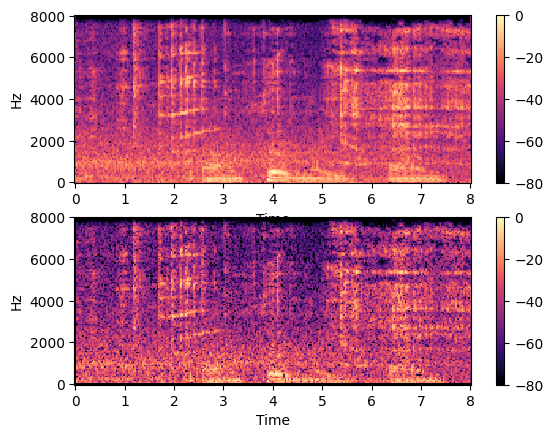

In [153]:
preds_np = torch.complex(preds, aud_spec.imag).squeeze().numpy()
aud_spec_np = aud_spec.squeeze().numpy()

plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(aud_spec_np, ref=np.max),
                         x_axis='time', y_axis='linear', sr=16000)
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(preds_np, ref=np.max),
                         x_axis='time', y_axis='linear', sr=16000)
plt.colorbar()

In [114]:
wav1, sr1 = torchaudio.load('Vanessa_Kitchen_Sample.wav')

duration = (int)(wav1.shape[1]/sr1)
sec_choice = random.choice([i for i in range(0, duration-2)])
wav1_randsec = wav1[:,sec_choice*sr1:(sec_choice+2)*sr1]

wav1_spec = spectro_fn(wav1_randsec)

model.eval()
with torch.inference_mode():
    pred_spec = model(wav1_spec.real)

y_pred = inv_spectro_fn(torch.complex(pred_spec, wav1_spec.imag))

display(Audio(wav1_randsec, rate=sr1))
display(Audio(y_pred, rate=sr1))

In [115]:
# After 4 iterations of training on the above dataset we save the model
# Conf00: Same as the LS one
# Conf01: lr-0.01
# Model01: new model, Conf00: basic conf/corrected loss fn
# Model01: new model, Conf01: basic conf/corrected loss fn - more iterations
# Model02: new model, Conf02: spectrogram params changed - 20 rounds
# Model00: new model, Conf03: increased the duration to 2 secs - 10 rounds
torch.save(model.state_dict(), 'models/model00_conf03.pt')